This notebook is for reproducing the paper with ResNet. Biggest TODO: separate saving data between iterations.

# Common

These sections include code common to both ResNet and Inception.

## Dependencies

Let's setup and configure dependencies. Note that since torchviz is used, graphviz needs to be specially installed.

In [1]:
%load_ext tensorboard

import contextlib
from io import BytesIO
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from PIL import Image
import random
import time
import timm
import torch
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.datasets as datasets
from torchvision.io import ImageReadMode
from torchvision.io import read_image
from torchvision import transforms as T
from torchviz import make_dot # This requires external downloads as well
import tqdm

In [2]:
# Reproducibility
def seed_worker(worker_id):
    """
    Sets the seed of the worker to depend on the initial seed. Credit to
    https://pytorch.org/docs/stable/notes/randomness.html
    """
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
torch.manual_seed(0)
# For DataLoaders
g = torch.Generator().manual_seed(0)

In [3]:
# Prepare progress bar
tqdm_variant = tqdm.tqdm # Assume not in Jupyter
try:
    # Credit https://stackoverflow.com/a/39662359
    shell_name = get_ipython().__class__.__name__
    if shell_name == "ZMQInteractiveShell":
        # Case in Jupyter
        tqdm_variant = tqdm.notebook.tqdm
except NameError:
    # Probably no iPhython instance, just use standard
    pass

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Plotting and Debugging Tools

Let's create some helpful functions for plotting.

In [5]:
# Adapted from Steven's ModelExamples
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [6]:
def display_batch_sample(loader):
    dataiter = iter(loader)
    imgs, labels = next(dataiter)
    img_grid = torchvision.utils.make_grid(imgs)
    imgs, labels = imgs.to(device), labels.to(device)
    matplotlib_imshow(img_grid)

In [7]:
def plot_cumulative_dist(
    baseline_observations,
    stabilized_observations
):
    """Plot our reproduction of Figure 7."""
    fig, ax = plt.subplots()
    ax.set_title("Cumulative Distributions")
    ax.set_xlabel("Feature Distance", fontweight="bold", loc="left")
    ax.set_ylabel("Cumulative Fraction", fontweight="bold", loc="top")
    ax.hist(
        baseline_observations,
        round(np.sqrt(len(baseline_observations))),
        density=True,
        histtype="step",
        cumulative=True,
        label="Baseline"
    )
    if len(stabilized_observations) > 0:
        ax.hist(
            stabilized_observations,
            round(np.sqrt(len(stabilized_observations))),
            density=True,
            histtype="step",
            cumulative=True,
            label="Stabilized"
        )
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.tick_params(axis="x", direction="in", pad=-15)
    ax.tick_params(axis="y", direction="in", pad=-22)
    ax.set_yticks([0.2,0.4,0.6,0.8,1.0])
    ax.set_yticklabels(
        ["20%","40%","60%","80%","100%"],
        {"fontweight" : "bold", "verticalalignment" : "top"}
    )
    ax.legend(loc="upper left")
    ax.grid()
    fig.savefig(
        os.path.join(
            os.path.abspath(""),
            f"cumulative_dists_{int(time.time()) % 1000000:06}.png"
        )
    )
    fig.show()

In [8]:
def show_first_triplet(queries, positives, negatives):
    a, b, c = queries[0], positives[0], negatives[0]
    ToPIL = T.ToPILImage() # Converting function
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(ToPIL(a))
    ax[1].imshow(ToPIL(b))
    ax[2].imshow(ToPIL(c))
    fig.show()

In [9]:
def debug_distances(triplet_ranking_model, batch, item_idx=0):
    with torch.no_grad():
        output = triplet_ranking_model(*map(lambda x : x.to(device), batch))
        qfeat = output[item_idx][0]
        pfeat = output[item_idx][1]
        nfeat = output[item_idx][2]
        pos_dist = torch.sqrt(((qfeat - pfeat)**2).sum()).item()
        neg_dist = torch.sqrt(((qfeat - nfeat)**2).sum()).item()
        print(f"Distance to positive: {pos_dist}, to negative: {neg_dist}")

In [10]:
def plot_precision_vs_quality(
    qualities,
    baseline_precision,
    stabilized_precision
):
    plt.plot(qualities, baseline_precision, label="Baseline")
    plt.plot(qualities, stabilized_precision, label=r"$\alpha=0.01$")
    plt.xticks(qualities[2:-1:2], [f"{quality}.00%" for quality in qualities[2:-1:2]])
    plt.xlim(100, 0)
    plt.xlabel("JPEG quality", fontweight="bold", loc="left")
    plt.ylabel("Precision@top-1", loc="top")
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    plt.gca().tick_params(axis="x", direction="in", pad=-15)
    plt.gca().tick_params(axis="y", direction="in", pad=-22)
    plt.legend(loc="upper center")
    plt.grid()
    fig = plt.gcf()
    fig.savefig(
        os.path.join(
            os.path.abspath(""),
            f"precision_vs_quality_{int(time.time()) % 1000000:06}.png"
        )
    )
    plt.show()

This part is also helpful for storing results of training:

In [11]:
def _def_save_filename(iteration_number : int, is_model : bool):
    """
    Returns a save filename from an iteration number, and whether the
    thing being saved is the model or the loss progress.
    """
    # Make sure inputs are okay (no directory traversal attacks!)
    if not isinstance(iteration_number, int):
        raise TypeError("Iteration number should be an integer.")

    # Retrieve proper name
    if is_model:
        return os.path.join(
            os.path.dirname(os.path.abspath("")),
            f"model_save_{iteration_number}_{int(time.time())%1000000:06}.pt"
        )
    return os.path.join(
        os.path.dirname(os.path.abspath("")),
        f"progress_save_{iteration_number}_{int(time.time())%1000000:06}.pt"
    )

#
# This class will make recording information easier
#
class TrainResult:
    """
    Hold the results of a training round. Basically a nice wrapper.

    Losses and accuracies should be averages over a batch for plot
    labels to make sense.

    Use whichever storage makes sense, but if one doesn't use the
    storage then don't expect the corresponding plots to do anything.
    """

    def __init__(self, model):
        """
        Constructor - prepare local variables. Include model since the
        one provided to trainer will likely be moved to a different
        device. Provide the one that is actually trained here, and then
        it can be used.
        """
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_accuracy_history = []
        self.val_accuracy_history = []
        self.time_training = 0.0
        self.time_validating = 0.0
        self.model = model

    def plot_loss_train_valid_curves(self, ax, show_legend : bool=True):
        """Use matplotlib to show training curves. Supply axis in ax."""
        ax.plot(self.train_loss_history, label="Train")
        ax.plot(self.val_loss_history, label="Test")
        ax.set_title(f"Model Loss")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
        if show_legend:
            ax.legend()

    def plot_accuracy_train_valid_curves(self, ax, show_legend=True):
        """Use matplotlib to show training curves. Supply axis in ax."""
        ax.plot(self.train_accuracy_history, label="Train")
        ax.plot(self.val_accuracy_history, label="Test")
        ax.set_title(f"Model Accuracy")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Accuracy")
        if show_legend:
            ax.legend()

    def print_time_info(self):
        """Prints some lines with information about timing."""
        print(f"Spent {round(self.time_training)} seconds training.")
        print(f"Spent {round(self.time_validating)} seconds evaluating.")

    def full_analysis(self, axs):
        """Display all analysis plots and print time information."""
        if len(self.train_loss_history) > 0:
            self.plot_loss_train_valid_curves(axs[0])
        if len(self.train_accuracy_history) > 0:
            self.plot_accuracy_train_valid_curves(axs[1])
        if self.time_training > 0.0:
            self.print_time_info()

    def save(self, save_filename_func, count : int=0):
        """
        Uses the save_filename_func provided with the count to create
        files that save the models current weights and the training
        progress so far.

        For count, 0 is by convention the final version.
        """
        # Save model
        torch.save(self.model.state_dict(), save_filename_func(count, True))
        # Save progress
        with open(save_filename_func(count, False), "wb") as file_obj:
            pickle.dump(
                {
                    "train_loss_history" : self.train_loss_history,
                    "val_loss_history" : self.val_loss_history,
                    "train_accuracy_history" : self.train_accuracy_history,
                    "val_accuracy_history" : self.val_accuracy_history,
                    "time_training" : self.time_training,
                    "time_validating" : self.time_validating
                }, file_obj
            )

In [12]:
def gradient_sanity_display(model, input_iter):
    """
    Show a computational graph for a model on device given an iterable
    of inputs to provide to the model.
    """
    res = model(*[item.to(device) for item in input_iter])
    return make_dot(res, params=dict(model.named_parameters()))

## Metrics

Let's prepare some evaluation functions.

In [13]:
def classifier_get_accuracy(model_output, labels):
    """
    Given model output and labels, finds the average accuracy over the 
    batch.
    """
    preds = model_output.topk(1, dim=1)[1].t().flatten()
    return ((preds == labels).sum() / len(preds)).item()

In [14]:
def stable_classifier_get_accuracy(model_output, labels):
    """For stability trained classifier, finds the accuracy"""
    return (
        torch.sum(
            model_output[0].topk(1, dim=1)[1].t().flatten()
            == labels
        )
        / len(model_output[0])
   ).item()

## Experiments

Let's make some functions to run experiments on models.

For the following, see how closely the triplet ranking models think compressed versions of the same images are.

In [55]:
def make_observations(baseline_model, stabilized_model, imagefolder):
    """
    Given a model trained for triplet ranking, make duplicate detection
    observations.
    """
    baseline_observations = []
    stabilized_observations = []
    tensor_transform = inception_transform
    
    for img_name in tqdm_variant(os.listdir(imagefolder)):
        #
        # Deal with images
        #
        image_fpath = os.path.join(imagefolder, img_name)
        if "jpeg" in img_name.lower():
            original_img = Image.open(image_fpath).convert("RGB")
        else:
            continue
        # Thanks https://stackoverflow.com/a/30771751
        buffer = BytesIO()
        original_img.save(buffer, "JPEG", optimize=True, quality=50)
        compressed_img = Image.open(buffer).convert("RGB")
        
        orig_tensor = tensor_transform(original_img)
        comp_tensor = tensor_transform(compressed_img)
        orig_tensor = orig_tensor.view(1, *orig_tensor.shape)
        comp_tensor = comp_tensor.view(1, *comp_tensor.shape)
        #
        # Make observations
        #
        baseline_model.eval()
        if stabilized_model is not None:
            stabilized_model.eval()
        with torch.no_grad():
            # Baseline
            original_rep = nn.functional.normalize(baseline_model(orig_tensor))
            compressed_rep = nn.functional.normalize(baseline_model(comp_tensor))
            dist = torch.sqrt(((original_rep - compressed_rep)**2).sum())
            baseline_observations.append(dist)
            # Stabilized
            if stabilized_model is not None:
                original_rep = nn.functional.normalize(stabilized_model(orig_tensor))
                compressed_rep = nn.functional.normalize(stabilized_model(comp_tensor))
                dist = torch.sqrt(((original_rep - compressed_rep)**2).sum())
                stabilized_observations.append(dist)
            
    return baseline_observations, stabilized_observations

## Models

We'll similarly create model objects as we go along, but this section contains things that simplify making them.

### Helper Transformations

In [16]:
# Credit https://discuss.pytorch.org/t/how-to-add-noise-to-mnist-dataset-when-using-pytorch/59745
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return (
            tensor
            + torch.empty(tensor.size(), device=device).normal_() * self.std
            + self.mean
        )
    
    def __repr__(self):
        return (
            self.__class__.__name__
            + '(mean={0}, std={1})'.format(self.mean, self.std)
        )

In [17]:
# Applies an amount of JPEG compression to a PIL image    
class JPEGTransform(nn.Module):
    def __init__(self, quality=50):
        self.quality = quality
    
    def __call__(self, img):
        buffer = BytesIO()
        img.save(buffer, "JPEG", optimize=True, quality=self.quality)
        return Image.open(buffer)

ResNet is made to be used with data transformed as so:

In [18]:
resnet_transform = T.Compose([
    T.Resize((256,256)),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Wrappers

In [50]:
class TripletRanker(nn.Module):
    """Triplet ranking model."""
    
    def __init__(self, model):
        """Creates a triplet ranker out of the model."""
        super().__init__()
        self.model = model
        
        
    def forward(self, queries, positives, negatives):
        """Send batch of triplets through."""
        queries_encode = nn.functional.normalize(self.model(queries))
        positives_encode = nn.functional.normalize(self.model(positives))
        negatives_encode = nn.functional.normalize(self.model(negatives))
        return queries_encode, positives_encode, negatives_encode

In [20]:
class StabilityTrainingModel(torch.nn.Module):
    def __init__(self, other_model, perturbation=None):
        """
        Wraps another model to allow for stability training. May specify
        custom perturbation transformation.
        """
        super().__init__()
        self.model = other_model
        
        if perturbation is None:
            self.perturb = AddGaussianNoise(0, 0.04)
        else:
            self.perturb = perturbation
    
    def forward(self, x):
        """Apply the model to some input."""
        return self.model(x), self.model(self.perturb(x))

### Model Classes

In [21]:
# This will act like a class
def RobustResnet():
    """
    Retrieve a fresh ResNet ready for stability training and fine
    tuning.
    """
    bare_resnet = torchvision.models.resnet18(pretrained=True)
    for param in bare_resnet.parameters():
        param.requires_grad = False
    bare_resnet.fc = nn.Linear(512, CLASS_NUMBER, bias=True)
    
    return StabilityTrainingModel(bare_resnet)

In [22]:
# This will act like a class
def RobustInception():
    """
    Retrieve a fresh Inception ready for stability training and fine
    tuning.
    """
    bare_inception = torchvision.models.inception_v3(
        pretrained=True,
        aux_logits=False
    )
    for param in bare_inception.parameters():
        param.requires_grad = False
    bare_inception.fc = nn.Linear(2048, CLASS_NUMBER)
    
    return StabilityTrainingModel(bare_inception)

## Datasets

Let's prepare some datasets. First, we'll make a custom dataset.

In [23]:
# NOTE: an alternative to this paradigm is loading all the images using
# the transform as a catalogue onto main memory, then detach on access
# TODO - refactor
class TripletRankingDataset(torch.utils.data.Dataset):
    def __init__(self,
                 img_dir : str,
                 pos_per_img : int,
                 neg_per_pos : int,
                 transform=None,
                 training=True
                ):
        """
        Point at directory which has subdirectories corresponding to
        each class. Supply the number of positive images per image in
        the subdirectories and the number of negative images to combine
        with.
        """
        if transform is None:
            transform = nn.Identity()
        self.transform = transform
        self.mode = "RGB"#ImageReadMode.RGB
        
        #
        # Initialize triplets
        #
        self.triplets = [ ]
        
        if training:
            self._train_init(img_dir, pos_per_img, neg_per_pos)
        else:
            self._val_init(img_dir, pos_per_img, neg_per_pos)
        
    def _train_init(self, img_dir, pos_per_img, neg_per_pos):
        # Generate randoms first, index into later. Need to count
        # Iterate over classes
        class_names = os.listdir(img_dir)
        if os.path.exists(os.path.join(img_dir, class_names[0], "images")):
            subdirectories_paths = list(map(
                lambda x : os.path.join(img_dir, x, "images"),
                class_names
            ))
        else:
            subdirectories_paths = list(map(
                lambda x : os.path.join(img_dir, x),
                class_names
            ))
        for subdir_path in subdirectories_paths:
            img_per_class = len(os.listdir(subdir_path))
            break
        randoms = np.random.randint(
            0,
            img_per_class,
            (
                len(subdirectories_paths),
                img_per_class,
                pos_per_img,
                neg_per_pos + 1 # Last for positive selection
            ),
            dtype="int16"
        )
        
        # TODO - this method inefficient, only need to hold 2 numbers,
        # some string format info
        # DANGER - potential for loops with symbolic/hard links
        # Iterate over classes
        for subdir_idx, subdir_path in enumerate(subdirectories_paths):
            exclude_subdir_idx =  [
                            *range(subdir_idx),
                            *range(
                                subdir_idx + 1,
                                len(subdirectories_paths)
                            )
                        ]
            # Iterate over images
            for img_idx, img in enumerate(os.listdir(subdir_path)):
                img_path = os.path.join(subdir_path, img)
                # Iterate over alike images
                for pos_it in range(pos_per_img):
                    pos_rand = randoms[subdir_idx][img_idx][pos_it][-1]
                    # Adjust on equal
                    if pos_rand == pos_it:
                        if pos_rand == 0:
                            pos_rand += 1
                        else:
                            pos_rand -= 1
                    # Form name
                    pos_path = os.path.join(
                        subdir_path,
                        f"{class_names[subdir_idx]}_{pos_rand}.JPEG"
                    )
                    # Need more randoms for next step
                    neg_class_rands = np.random.choice(
                        exclude_subdir_idx,
                        neg_per_pos,
                        replace=True
                    )
                    # Iterate over dissimilar images
                    for neg_it in range(neg_per_pos):
                        class_rand = neg_class_rands[neg_it]
                        neg_class_path = subdirectories_paths[class_rand]
                        neg_class = class_names[class_rand]
                        neg_rand = randoms[subdir_idx][img_idx][pos_it][neg_it]
                        # Form name
                        neg_path = os.path.join(
                            neg_class_path,
                            f"{neg_class}_{neg_rand}.JPEG"
                        )
                        # Append
                        self.triplets.append((img_path, pos_path, neg_path))
                        
    def _val_init(self, img_dir, pos_per_img, neg_per_pos):
        # Generate randoms first, index into later. Need to count
        # Iterate over classes
        class_names = os.listdir(img_dir)
        
        if os.path.exists(os.path.join(img_dir, class_names[0], "images")):
            subdirectories_paths = list(map(
                lambda x : os.path.join(img_dir, x, "images"),
                class_names
            ))
        else:
            subdirectories_paths = list(map(
                lambda x : os.path.join(img_dir, x),
                class_names
            ))
            
        img_per_class = dict()
        img_names = []
        for idx in range(len(class_names)):
            subdir_path = subdirectories_paths[idx]
            class_name = class_names[idx]
            img_names.append(list(os.listdir(subdir_path)))
            img_per_class[class_name] = len(img_names[-1])
        
        # TODO - this method inefficient, only need to hold 2 numbers,
        # some string format info
        # DANGER - potential for loops with symbolic/hard links
        # Iterate over classes
        for subdir_idx, subdir_path in enumerate(subdirectories_paths):
            exclude_subdir_idx =  [
                            *range(subdir_idx),
                            *range(
                                subdir_idx + 1,
                                len(subdirectories_paths)
                            )
                        ]
            this_dir = img_names[subdir_idx]
            # Iterate over images
            for img_idx, img in enumerate(this_dir):
                img_path = os.path.join(subdir_path, img)
                # Iterate over alike images
                for pos_it in range(pos_per_img):
                    # Form name
                    rand_idx = np.random.choice([
                        *range(pos_it),
                        *range(pos_it + 1, img_per_class[class_names[pos_it]])
                    ])
                    pos_name = this_dir[rand_idx]
                    # Form path
                    pos_path = os.path.join(subdir_path, pos_name)
                    # Need more randoms for next step
                    neg_class_rands = np.random.choice(
                        exclude_subdir_idx,
                        neg_per_pos,
                        replace=True
                    )
                    # Iterate over dissimilar images
                    for neg_it in range(neg_per_pos):
                        class_rand = neg_class_rands[neg_it]
                        neg_class_path = subdirectories_paths[class_rand]
                        neg_class = class_names[class_rand]
                        # Select from the directory
                        neg_name = np.random.choice(img_names[class_rand])
                        # Form name
                        neg_path = os.path.join(neg_class_path, neg_name)
                        # Append
                        self.triplets.append((img_path, pos_path, neg_path))
        
    def __len__(self):
        return len(self.triplets)
    
    def __getitem__(self, idx):
        this_triplet = self.triplets[idx]
        #query = self.transform(read_image(this_triplet[0], self.mode))
        #positive = self.transform(read_image(this_triplet[1], self.mode))
        #negative = self.transform(read_image(this_triplet[2], self.mode))
        query = self.transform(Image.open(this_triplet[0]).convert(self.mode))
        positive = self.transform(Image.open(this_triplet[1]).convert(self.mode))
        negative = self.transform(Image.open(this_triplet[2]).convert(self.mode))
        return query, positive, negative

The following is helpful to keep around:

In [24]:
data_dir = os.path.join(os.path.abspath(""), "tiny-imagenet-200")

We'll create dataset objects as we go since they take up memory, but these are used across tasks:

In [25]:
BATCH_SIZE = 64

class_dataset_train = datasets.ImageFolder(
    os.path.join(data_dir, "train"),
    transform=resnet_transform
)
train_loader = torch.utils.data.DataLoader(
    class_dataset_train,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=True
)

## Training Functions

Factoring some common patterns:

In [26]:
def classifier_epoch(
    model,
    loader,
    optimizer,
    device,
    loss_func,
    result,
    training=True,
    stability_training=False
):
    loss = torch.Tensor([0])
    avg_loss = 0
    
    if training:
        model.train()
    else:
        model.eval()
    start = time.perf_counter()
    with contextlib.ExitStack() as stack: # For validation/training
        if not training:
            stack.enter_context(torch.no_grad()) # No gradients
        for imgs, labels in tqdm_variant(
            loader,
            desc=f"{'Training' if training else 'Validation'} Iteration",
            disable=False
        ):
            if training:
                # Prepare optimizer
                optimizer.zero_grad(set_to_none=True)

            # Prepare relevant variables
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)

            # Determine loss
            if stability_training:
                loss = loss_func(*out, labels)
            else:
                loss = loss_func(out, labels)

            # Store intermediate results - note average over batch
            item = loss.item()
            avg_loss += item
            if training:
                result.train_loss_history.append(item)
            else:
                result.val_loss_history.append(item)

            # Calculate accuracy
            if stability_training:
                acc = stable_classifier_get_accuracy(out, labels)
            else:
                acc = classifier_get_accuracy(out, labels)
            
            # Save accuracy
            if training:
                result.train_accuracy_history.append(acc)
            else:
                result.val_accuracy_history.append(acc)

            if training:
                loss.backward() # Get gradients
                optimizer.step() # Descend gradients
    end = time.perf_counter()
    if training:
        result.time_training += end - start
    else:
        result.time_validating += end - start
    
    return avg_loss / len(loader)

In [27]:
def triplet_epoch(
    model,
    loader,
    optimizer,
    device,
    loss_func,
    result,
    training=True
):
    loss = torch.Tensor([0])
    avg_loss = 0
    
    if training:
        model.train()
    else:
        model.eval()
    start = time.perf_counter()
    with contextlib.ExitStack() as stack: # For validation/training
        if not training:
            stack.enter_context(torch.no_grad()) # No gradients
        for queries, positives, negatives in tqdm_variant(
            loader,
            desc=f"{'Training' if training else 'Validation'} Iteration",
            disable=False
        ):
            if training:
                # Prepare optimizer
                optimizer.zero_grad(set_to_none=True)

            # Prepare relevant variables
            queries = queries.to(device)
            positives = positives.to(device)
            negatives = negatives.to(device)
            out = model(queries, positives, negatives)

            # Determine loss
            loss = loss_func(*out)

            # Store intermediate results - note average over batch
            item = loss.item()
            avg_loss += item
            if training:
                result.train_loss_history.append(item)
            else:
                result.val_loss_history.append(item)

            if training:
                loss.backward() # Get gradients
                optimizer.step() # Descend gradients
    end = time.perf_counter()
    if training:
        result.time_training += end - start
    else:
        result.time_validating += end - start
    
    return avg_loss / len(loader)

## Miscellaneous Helpers


Some constants:

In [28]:
# Weight of the stability objective
ALPHA = 0.01

CLASS_NUMBER = 200

Loss function things for stability trained classifiers:

In [29]:
classifier_objective = nn.CrossEntropyLoss()
classifier_stability_loss = nn.CrossEntropyLoss()
distort_envelope = nn.Softmax(dim=1) # Converts to probabilities

def full_loss(clean_output, distort_output, label):
    """Note that this will apply softmax to distort_output."""
    return (
        classifier_objective(clean_output, label)
        + ALPHA * classifier_stability_loss(clean_output, distort_envelope(distort_output))
    )

These are common to multiple sections:

In [30]:
resnet_loss = classifier_objective

In [31]:
s_resnet_loss = full_loss

In [32]:
inception_transform = T.Compose([
    T.Resize(299),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# ResNet

## Training

Now, let's do some training!

### Classifiers

#### Baseline

Let's train a baseline ResNet. First, prepare the data.

In [42]:
class_dataset_val = datasets.ImageFolder(
    os.path.join(data_dir, "val"),
    transform=resnet_transform
)

batch_size = 64
val_loader = torch.utils.data.DataLoader(
    class_dataset_val,
    batch_size=batch_size,
    num_workers=0
)

Next, prepare the model object.

In [34]:
# Default variation. Note pretrained
resnet = torchvision.models.resnet18(pretrained=True)

# Freeze all layers
for param in resnet.parameters():
    param.requires_grad = False
    
# Replace last, note now unfrozen and we'll fine tune
resnet.fc = nn.Linear(512, 200, bias=True)

# Send to GPU, if possible
resnet = resnet.to(device)

Learning controllers:

In [35]:
optimizer = optim.SGD(resnet.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=2,
    threshold=0.1
)
# May try OneCycleLR, annealers

See the helpers for the loss function.

Keep the result in here:

In [37]:
resnet_result = TrainResult(resnet)

The actual training loop:

In [ ]:
# Train for some number of epochs
EPOCH_COUNT = 20
SAVE_PERIOD = 3

best_loss = float("inf")
best_count = 0
for epoch in tqdm_variant(
    range(EPOCH_COUNT),
    desc=f"Epoch",
    unit="epoch",
    disable=False
):
    # Debug learning rate
    print(f"Current Learning Rate: {optimizer.param_groups[0]['lr']}")
    
    # Train
    train_loss = classifier_epoch(
        resnet,
        train_loader,
        optimizer,
        device,
        resnet_loss,
        resnet_result
    )

    # Validation
    val_loss = classifier_epoch(
        resnet,
        val_loader,
        device,
        resnet_loss,
        resnet_result,
        training=False
    )
    
    # Update scheduling
    scheduler.step(val_loss)
    
    # Save a copy just in case
    if val_loss < best_loss:
        torch.save(
            resnet, 
            os.path.join(
                os.path.abspath(""),
                f"best_resnet_classifier_{best_count}" \
                f"_{int(time.time()) % 1000000:06}.pt"
            )
        )
        best_count += 1
        best_loss = val_loss
        
    if epoch % SAVE_PERIOD == SAVE_PERIOD - 1:
        torch.save(
            resnet,
            os.path.join(
                os.path.abspath(""),
                f"resnet_classifier_{epoch}_{int(time.time()) % 1000000:06}.pt"
            )
        )

    # Print the last loss calculated and the epoch
    print(f"\nEpoch {epoch}: Training Loss: {train_loss}, " \
          f"Validation Loss: {val_loss}")

Let's view the results:

In [ ]:
fig, axs = plt.subplots(1, 2)
resnet_result.full_analysis(axs)

#### Stability Trained

Let's stability train ResNet. We can use the same datasets and loaders. Let's prepare the model object.

In [125]:
stable_resnet = RobustResnet().to(device)

First, a quick sanity check of gradients:

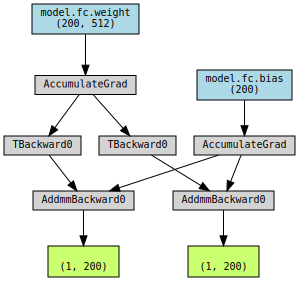

In [126]:
gradient_sanity_display(
    stable_resnet,
    [next(iter(train_loader))[0][0].reshape(1, 3, 224, 224)]
)

Next sanity check, how are the weights?

In [127]:
print(list(stable_resnet.model.fc.parameters()))

[Parameter containing:
tensor([[ 0.0073, -0.0071, -0.0009,  ...,  0.0216,  0.0329, -0.0283],
        [-0.0129, -0.0424,  0.0151,  ...,  0.0160,  0.0379, -0.0258],
        [ 0.0290,  0.0259, -0.0220,  ...,  0.0002, -0.0416,  0.0307],
        ...,
        [ 0.0433, -0.0088, -0.0040,  ...,  0.0174,  0.0291, -0.0318],
        [ 0.0203, -0.0184, -0.0100,  ...,  0.0415, -0.0289, -0.0232],
        [-0.0161,  0.0177,  0.0332,  ...,  0.0050, -0.0275,  0.0085]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 1.8264e-02,  8.2651e-03, -1.8287e-02, -5.1264e-03,  2.3474e-02,
         3.6429e-02, -2.5332e-02,  3.1460e-02, -9.8708e-03, -3.0398e-02,
        -3.8438e-02, -1.3270e-02,  9.8759e-04, -4.4047e-02,  2.5429e-02,
         1.5400e-02,  8.2721e-03, -1.7918e-03,  6.0061e-03,  2.8976e-02,
         8.5340e-03,  2.2457e-02, -1.9287e-02, -2.0829e-02,  3.4783e-02,
        -2.5888e-02, -1.2726e-02, -3.0649e-02,  3.8350e-02, -3.2814e-02,
         1.2518e-02,  2.4499e-02,  2.5

Learning controllers, note that learning rate starts slower now:

In [128]:
s_optimizer = optim.SGD(stable_resnet.parameters(), lr=0.005)
s_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    s_optimizer,
    factor=0.5,
    patience=2,
    threshold=0.1
)
# May try OneCycleLR, annealers

See the helpers for the loss function.

Keep the result in here:

In [130]:
s_resnet_result = TrainResult(stable_resnet)

The actual training loop:

In [131]:
# Train for some number of epochs
S_EPOCH_COUNT = 20
S_SAVE_PERIOD = 3

s_best_loss = float("inf")
s_best_count = 0
for epoch in tqdm_variant(
    range(S_EPOCH_COUNT),
    desc=f"Epoch",
    unit="epoch",
    disable=False
):
    # Debug learning rate
    print(f"Current Learning Rate: {s_optimizer.param_groups[0]['lr']}")
    
    # Train
    train_loss = classifier_epoch(
        stable_resnet,
        train_loader,
        s_optimizer,
        device,
        s_resnet_loss,
        s_resnet_result,
        stability_training=True
    )

    # Validation
    val_loss = classifier_epoch(
        stable_resnet,
        val_loader,
        s_optimizer,
        device,
        s_resnet_loss,
        s_resnet_result,
        training=False,
        stability_training=True
    )
    
    # Update scheduling
    s_scheduler.step(val_loss)
    
    # Save a copy just in case
    if val_loss < s_best_loss:
        torch.save(
            stable_resnet, 
            os.path.join(
                os.path.abspath(""),
                f"best_stable_resnet_classifier_{s_best_count}" \
                f"_{int(time.time()) % 100000:06}.pt"
            )
        )
        s_best_count += 1
        s_best_loss = val_loss
        
    if epoch % S_SAVE_PERIOD == S_SAVE_PERIOD - 1:
        torch.save(
            stable_resnet,
            os.path.join(
                os.path.abspath(""),
                f"stable_resnet_classifier_{epoch}_" \
                f"{int(time.time()) % 100000:06}.pt"
            )
        )

    # Print the average loss calculated and the epoch
    print(f"\nEpoch {epoch}: Training Loss: {train_loss}, " \
          f"Validation Loss: {val_loss}")

Epoch:   0%|          | 0/20 [00:00<?, ?epoch/s]

Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 0: Training Loss: 4.727948836767742, Validation Loss: 4.084477017639549
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 1: Training Loss: 3.674960175311039, Validation Loss: 3.2731017041358217
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 2: Training Loss: 3.079790781189521, Validation Loss: 2.844098055438631
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 3: Training Loss: 2.735764454819038, Validation Loss: 2.579060474019142
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 4: Training Loss: 2.5209649991165426, Validation Loss: 2.4024654391464915
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 5: Training Loss: 2.376510003630503, Validation Loss: 2.3007565706398836
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 6: Training Loss: 2.2721807902544184, Validation Loss: 2.2295108946265687
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 7: Training Loss: 2.192590256875246, Validation Loss: 2.1606985266041603
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 8: Training Loss: 2.130990964208592, Validation Loss: 2.1133614839262265
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 9: Training Loss: 2.0818074992735722, Validation Loss: 2.0866039023277865
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 10: Training Loss: 2.0409617253930157, Validation Loss: 2.048759793020358
Current Learning Rate: 0.0025


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 11: Training Loss: 2.008505058303828, Validation Loss: 2.0371640267645477
Current Learning Rate: 0.0025


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 12: Training Loss: 1.992997704754254, Validation Loss: 2.0173599731390643
Current Learning Rate: 0.0025


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 13: Training Loss: 1.9773476194740485, Validation Loss: 2.007489614046303
Current Learning Rate: 0.00125


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 14: Training Loss: 1.9642766243513012, Validation Loss: 2.0208338631945812
Current Learning Rate: 0.00125


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 15: Training Loss: 1.9556046149247133, Validation Loss: 1.9952780638530756
Current Learning Rate: 0.00125


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 16: Training Loss: 1.9502355649695515, Validation Loss: 2.0010284640986447
Current Learning Rate: 0.000625


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 17: Training Loss: 1.9436827919380983, Validation Loss: 1.9855448728913714
Current Learning Rate: 0.000625


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 18: Training Loss: 1.9389324397973655, Validation Loss: 1.9762624524960852
Current Learning Rate: 0.000625


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 19: Training Loss: 1.9368133958302776, Validation Loss: 1.975199190674314


Let's view the results:

Spent 5141 seconds training.
Spent 501 seconds evaluating.


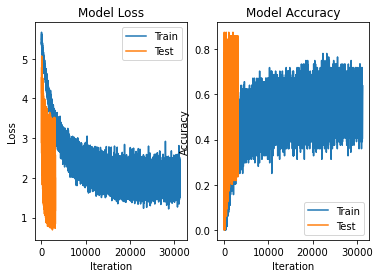

In [132]:
fig, axs = plt.subplots(1, 2)
s_resnet_result.full_analysis(axs)

Next, let's save it with a special name.

In [133]:
torch.save(
    stable_resnet, 
    os.path.join(
        os.path.abspath(""),
        "stability_resnet.pt"
    )
)
s_resnet_result.save(_def_save_filename)

### Triplet Ranking

Next, let's train some triplet ranking models.

#### Baseline

Prepare data:

In [62]:
train_path = os.path.join(data_dir, "train")
val_path = os.path.join(data_dir, "val")
trd = TripletRankingDataset(train_path, 2, 2, transform=resnet_transform)
trd_val = TripletRankingDataset(
    val_path,
    1,
    1,
    transform=resnet_transform,
    training=False
)

batch_size = 32
tr_train_loader = torch.utils.data.DataLoader(trd, batch_size=batch_size,
                                     num_workers=0, shuffle=True)
tr_val_loader = torch.utils.data.DataLoader(trd_val, batch_size=batch_size,
                                     num_workers=0)

Prepare new model that maps into a 64 dimensional encoding space. Note that this is less than the 200 classes.

In [79]:
resnet_encoder = torchvision.models.resnet18(pretrained=True)

for param in resnet_encoder.parameters():
    param.requires_grad = False
    
resnet_encoder.fc = nn.Linear(512, 64, bias=True) # 64-Dimensional Encoding

resnet_triplet_ranking = TripletRanker(resnet_encoder).to(device)

Training controllers:

In [80]:
rtr_optimizer = optim.SGD(resnet_triplet_ranking.parameters(), lr=0.01)
rtr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    rtr_optimizer,
    factor=0.5,
    patience=2,
    threshold=0.1
)
# May try OneCycleLR, annealers

Result:

In [81]:
rtr_result = TrainResult(resnet_triplet_ranking)

Triplet loss:

In [82]:
rtr_loss = nn.TripletMarginLoss(1.0, 2)

Training loop:

In [ ]:
# Train for some number of epochs
RTR_EPOCH_COUNT = 20
RTR_SAVE_PERIOD = 3

loss = torch.Tensor([0])
rtr_best_loss = float("inf")
rtr_best_count = 0
for epoch in tqdm_variant(
    range(RTR_EPOCH_COUNT),
    desc=f"Epoch",
    unit="epoch",
    disable=False
):
    # Debug learning rate
    print(f"Current Learning Rate: {rtr_optimizer.param_groups[0]['lr']}")
    
    train_loss = triplet_epoch(
        resnet_triplet_ranking,
        tr_train_loader,
        rtr_optimizer,
        device,
        rtr_loss,
        rtr_result
    )

    val_loss = triplet_epoch(
        resnet_triplet_ranking,
        tr_val_loader,
        rtr_optimizer,
        device,
        rtr_loss,
        rtr_result,
        training=False
    )
    
    # Save a copy for safety
    if val_loss < rtr_best_loss:
        torch.save(
            resnet_triplet_ranking, 
            os.path.join(
                os.path.abspath(""),
                f"best_rtr_{best_count}_{int(time.time()) % 1000000:06}.pt"
            )
        )
        rtr_best_count += 1
        rtr_best_loss = val_loss
        
    if epoch % RTR_SAVE_PERIOD == RTR_SAVE_PERIOD - 1:
        torch.save(
            resnet_triplet_ranking,
            os.path.join(
                os.path.abspath(""),
                f"rtr_{epoch}_{int(time.time()) % 1000000:06}.pt"
            )
        )

    # Print the last loss calculated and the epoch
    print(f"\nEpoch {epoch}: Training Loss: {train_loss}, " \
          f"Validation Loss: {val_loss}")

Let's double check gradient calculations went well:

In [ ]:
gradient_sanity_display(resnet_triplet_ranking, next(iter(tr_train_loader))[0])

#### Stability Trained

In [ ]:
# TODO

## Experiments and Plot Generation

### Classifier vs. JPEG

We'll see how precision declines with more JPEG. First, let's load the classifiers from save files.

In [93]:
loaded_stabilized_classifier = torch.load(
    os.path.join(
        os.path.abspath(""),
        "stability_resnet.pt"
    ),
    device
)

loaded_baseline_classifier = torch.load(
    os.path.join(
        os.path.abspath(""),
        "resnet.pt"
    ),
    device
)

Sanity checks:

In [94]:
print(loaded_baseline_classifier)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [95]:
print(loaded_stabilized_classifier)

StabilityTrainingModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [96]:
gradient_sanity_display(
    loaded_baseline_classifier,
    [next(iter(train_loader))[0][0].reshape(1, 3, 224, 224)]
)

NameError: name 'train_loader' is not defined

In [97]:
gradient_sanity_display(
    loaded_stabilized_classifier,
    [next(iter(train_loader))[0][0].reshape(1, 3, 224, 224)]
)

NameError: name 'train_loader' is not defined

Looking good, so we're ready. We'll increase the JPEG levels as we experiment. Note that we can reuse some code for this. The data collection:

In [106]:
BATCH_SIZE = 512

qualities = list(range(100, 0, -10))
baseline_precision = [ ]
stabilized_precision = [ ]

for quality in tqdm_variant(
    qualities,
    desc=f"Experiment",
    unit="experiment"
):
    #
    # Prepare the data
    #
    apply_jpeg = JPEGTransform(quality)
    
    this_dataset = datasets.ImageFolder(
        os.path.join(data_dir, "val"),
        transform=T.Compose([apply_jpeg, resnet_transform])
    )
    this_loader = torch.utils.data.DataLoader(
        this_dataset,
        batch_size=BATCH_SIZE,
        num_workers=0
    )
    
    tmp_result = TrainResult(None)

    #
    # Experiments
    #
    
    # Perform stabilized experiment
    _ = classifier_epoch(
            loaded_baseline_classifier,
            this_loader,
            None,
            device,
            resnet_loss,
            tmp_result,
            training=False
        )
    _ = classifier_epoch(
            loaded_stabilized_classifier,
            this_loader,
            None,
            device,
            s_resnet_loss,
            tmp_result,
            training=False,
            stability_training=True
        )
    
    #
    # Extract data
    #
    trial_size = len(tmp_result.val_accuracy_history) // 2
    inv_img_count = 1.0 / (len(this_dataset) // BATCH_SIZE)
    # Calculate baseline
    baseline_precision.append(
        sum(tmp_result.val_accuracy_history[:trial_size - 1]) * inv_img_count
    )
    stabilized_precision.append(
        sum(tmp_result.val_accuracy_history[trial_size:-1]) * inv_img_count
    )

    # No chances with memory management
    del tmp_result, this_loader, this_dataset

Experiment:   0%|          | 0/10 [00:00<?, ?experiment/s]

Validation Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Let's plot the results:

In [ ]:
plot_precision_vs_quality(qualities, baseline_precision, stabilized_precision)

Next, let's save the results.

In [127]:
with open(
    f"resnet_classifier_result_{int(time.time()) % 1000000:06}.pt",
    "wb"
) as file_obj:
    pickle.dump(
        {
            "baseline" : baseline_precision,
            "stabilized" : stabilized_precision
        }, file_obj
    )

# Inception v3

## Training

Now, let's do some training!

### Classifiers

#### Baseline

Let's train a baseline Inception v3. We'll need a new tranformation:

In [34]:
BATCH_SIZE = 64

inception_class_dataset_train = datasets.ImageFolder(
    os.path.join(data_dir, "train"),
    transform=inception_transform
)
inception_class_dataset_val = datasets.ImageFolder(
    os.path.join(data_dir, "val"),
    transform=inception_transform
)

inception_train_loader = torch.utils.data.DataLoader(
    inception_class_dataset_train,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=True
)
inception_val_loader = torch.utils.data.DataLoader(
    inception_class_dataset_val,
    batch_size=BATCH_SIZE,
    num_workers=0
)

Next, prepare the model object.

In [34]:
# Default variation. Note pretrained
inception = torchvision.models.inception_v3(pretrained=True, aux_logits=False)

# Freeze all layers
for param in inception.parameters():
    param.requires_grad = False
    
# Replace last, note now unfrozen and we'll fine tune
inception.fc = nn.Linear(2048, 200)

# Send to GPU, if possible
inception = inception.to(device)

Learning controllers:

In [42]:
inception_optimizer = optim.SGD(inception.parameters(), lr=0.002)
inception_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    inception_optimizer,
    factor=0.5,
    patience=2,
    threshold=0.1
)
# May try OneCycleLR, annealers

We'll create the loss function:

In [38]:
inception_loss = classifier_objective

Keep the result in here:

In [36]:
inception_result = TrainResult(inception)

The actual training loop:

In [ ]:
inception_best_loss = float("inf")
inception_best_count = 0

In [43]:
# Train for some number of epochs
INCEPTION_EPOCH_COUNT = 40 # + 2 from earlier run
INCEPTION_SAVE_PERIOD = 3

for epoch in tqdm_variant(
    range(INCEPTION_EPOCH_COUNT),
    desc=f"Epoch",
    unit="epoch",
    disable=False
):
    # Debug learning rate
    print(f"Current Learning Rate: {inception_optimizer.param_groups[0]['lr']}")
    
    # Train
    train_loss = classifier_epoch(
        inception,
        inception_train_loader,
        inception_optimizer,
        device,
        inception_loss,
        inception_result
    )

    # Validation
    val_loss = classifier_epoch(
        inception,
        inception_val_loader,
        inception_optimizer,
        device,
        inception_loss,
        inception_result,
        training=False
    )
    
    # Update scheduling
    inception_scheduler.step(val_loss)
    
    # Save a copy just in case
    if val_loss < inception_best_loss:
        torch.save(
            inception, 
            os.path.join(
                os.path.abspath(""),
                f"best_inception_classifier_{inception_best_count}" \
                f"_{int(time.time()) % 1000000:06}.pt"
            )
        )
        inception_best_count += 1
        inception_best_loss = val_loss
        
    if epoch % INCEPTION_SAVE_PERIOD == INCEPTION_SAVE_PERIOD - 1:
        torch.save(
            inception,
            os.path.join(
                os.path.abspath(""),
                f"inception_classifier_{epoch}_" \
                f"{int(time.time()) % 1000000:06}.pt"
            )
        )

    # Print the last loss calculated and the epoch
    print(f"\nEpoch {epoch}: Training Loss: {train_loss}, " \
          f"Validation Loss: {val_loss}")

Epoch:   0%|          | 0/40 [00:00<?, ?epoch/s]

Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 0: Training Loss: 5.056670257241316, Validation Loss: 4.865894499857714
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 1: Training Loss: 4.765042121030548, Validation Loss: 4.574183974296424
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 2: Training Loss: 4.485898364452086, Validation Loss: 4.291020212659411
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 3: Training Loss: 4.2230035175670055, Validation Loss: 4.0321453270638825
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 4: Training Loss: 3.9774061204223243, Validation Loss: 3.7874270077723606
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 5: Training Loss: 3.7550540530216368, Validation Loss: 3.559548504033666
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 6: Training Loss: 3.550001209543366, Validation Loss: 3.3650971400509975
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 7: Training Loss: 3.3670223065850373, Validation Loss: 3.192492527566898
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 8: Training Loss: 3.201516921140411, Validation Loss: 3.0297526956363847
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 9: Training Loss: 3.0601021520464524, Validation Loss: 2.875111984599168
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 10: Training Loss: 2.9329547972078136, Validation Loss: 2.762342267734989
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 11: Training Loss: 2.82149013585184, Validation Loss: 2.6536348025510264
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 12: Training Loss: 2.7206595253654573, Validation Loss: 2.5684371207170424
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 13: Training Loss: 2.6397757376147934, Validation Loss: 2.484230088580186
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 14: Training Loss: 2.5640033533843143, Validation Loss: 2.3979173086251424
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 15: Training Loss: 2.496462620837675, Validation Loss: 2.342229868196378
Current Learning Rate: 0.001


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 16: Training Loss: 2.4507997959604344, Validation Loss: 2.319715630476642
Current Learning Rate: 0.001


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 17: Training Loss: 2.4238469332208714, Validation Loss: 2.288271661017351
Current Learning Rate: 0.001


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 18: Training Loss: 2.3921537941568416, Validation Loss: 2.256896205009169
Current Learning Rate: 0.001


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 19: Training Loss: 2.369575960241063, Validation Loss: 2.219197902709815
Current Learning Rate: 0.001


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 20: Training Loss: 2.3462905734300765, Validation Loss: 2.214926406836054
Current Learning Rate: 0.0005


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 21: Training Loss: 2.326478780345587, Validation Loss: 2.1957151434224125
Current Learning Rate: 0.0005


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 22: Training Loss: 2.3177709778531272, Validation Loss: 2.1784073144766936
Current Learning Rate: 0.0005


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 23: Training Loss: 2.3073076217966206, Validation Loss: 2.1715496011600375
Current Learning Rate: 0.00025


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 24: Training Loss: 2.300820968735317, Validation Loss: 2.172228928584202
Current Learning Rate: 0.00025


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 25: Training Loss: 2.2946167045576176, Validation Loss: 2.179454798151733
Current Learning Rate: 0.00025


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 26: Training Loss: 2.2877146004867797, Validation Loss: 2.15374146904915
Current Learning Rate: 0.000125


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 27: Training Loss: 2.284143842418302, Validation Loss: 2.167112842486922
Current Learning Rate: 0.000125


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 28: Training Loss: 2.2833034385875184, Validation Loss: 2.1537601431463935
Current Learning Rate: 0.000125


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 29: Training Loss: 2.2785170389457305, Validation Loss: 2.1554141128139133
Current Learning Rate: 6.25e-05


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 30: Training Loss: 2.2794466085031257, Validation Loss: 2.1639120707845994
Current Learning Rate: 6.25e-05


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 31: Training Loss: 2.2759052605790657, Validation Loss: 2.149726507010733
Current Learning Rate: 6.25e-05


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 32: Training Loss: 2.273106117166164, Validation Loss: 2.152631440739723
Current Learning Rate: 3.125e-05


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 33: Training Loss: 2.2770736610286906, Validation Loss: 2.15784464368395
Current Learning Rate: 3.125e-05


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 34: Training Loss: 2.2728681693226576, Validation Loss: 2.1461011877485143
Current Learning Rate: 3.125e-05


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 35: Training Loss: 2.275738872096696, Validation Loss: 2.1327598421436966
Current Learning Rate: 1.5625e-05


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 36: Training Loss: 2.2777306862695053, Validation Loss: 2.1437813673809076
Current Learning Rate: 1.5625e-05


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 37: Training Loss: 2.2749727737880714, Validation Loss: 2.16389527442349
Current Learning Rate: 1.5625e-05


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 38: Training Loss: 2.2720691599452336, Validation Loss: 2.1588852230910285
Current Learning Rate: 7.8125e-06


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 39: Training Loss: 2.275567430757363, Validation Loss: 2.133050382516946


A bit more:

In [44]:
# Train for some number of epochs
INCEPTION_EPOCH_COUNT = 19
INCEPTION_SAVE_PERIOD = 3

for epoch in tqdm_variant(
    range(INCEPTION_EPOCH_COUNT),
    desc=f"Epoch",
    unit="epoch",
    disable=False
):
    # Debug learning rate
    print(f"Current Learning Rate: {inception_optimizer.param_groups[0]['lr']}")
    
    # Train
    train_loss = classifier_epoch(
        inception,
        inception_train_loader,
        inception_optimizer,
        device,
        inception_loss,
        inception_result
    )

    # Validation
    val_loss = classifier_epoch(
        inception,
        inception_val_loader,
        inception_optimizer,
        device,
        inception_loss,
        inception_result,
        training=False
    )
    
    # Update scheduling
    inception_scheduler.step(val_loss)
    
    # Save a copy just in case
    if val_loss < inception_best_loss:
        torch.save(
            inception, 
            os.path.join(
                os.path.abspath(""),
                f"best_inception_classifier_{inception_best_count}" \
                f"_{int(time.time()) % 1000000:06}.pt"
            )
        )
        inception_best_count += 1
        inception_best_loss = val_loss
        
    if epoch % INCEPTION_SAVE_PERIOD == INCEPTION_SAVE_PERIOD - 1:
        torch.save(
            inception,
            os.path.join(
                os.path.abspath(""),
                f"inception_classifier_{epoch}_" \
                f"{int(time.time()) % 1000000:06}.pt"
            )
        )

    # Print the last loss calculated and the epoch
    print(f"\nEpoch {epoch}: Training Loss: {train_loss}, " \
          f"Validation Loss: {val_loss}")

Epoch:   0%|          | 0/19 [00:00<?, ?epoch/s]

Current Learning Rate: 7.8125e-06


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 0: Training Loss: 2.27335202068529, Validation Loss: 2.1546620335548545
Current Learning Rate: 7.8125e-06


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 1: Training Loss: 2.273179232273358, Validation Loss: 2.14783038151492
Current Learning Rate: 3.90625e-06


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 2: Training Loss: 2.272046717633365, Validation Loss: 2.1543932727947355
Current Learning Rate: 3.90625e-06


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 3: Training Loss: 2.271953875104815, Validation Loss: 2.1568290154645395
Current Learning Rate: 3.90625e-06


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 4: Training Loss: 2.2736702397780317, Validation Loss: 2.151869792847117
Current Learning Rate: 1.953125e-06


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 5: Training Loss: 2.273718427330427, Validation Loss: 2.145241647768932
Current Learning Rate: 1.953125e-06


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 6: Training Loss: 2.269333175566436, Validation Loss: 2.152992787634491
Current Learning Rate: 1.953125e-06


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 7: Training Loss: 2.269668587109864, Validation Loss: 2.160851401128587
Current Learning Rate: 9.765625e-07


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 8: Training Loss: 2.2742290062852493, Validation Loss: 2.1431993929443847
Current Learning Rate: 9.765625e-07


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 9: Training Loss: 2.275236323561641, Validation Loss: 2.164456538334014
Current Learning Rate: 9.765625e-07


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 10: Training Loss: 2.275732147182628, Validation Loss: 2.1527489309857604
Current Learning Rate: 4.8828125e-07


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 11: Training Loss: 2.27299487552655, Validation Loss: 2.143401743500096
Current Learning Rate: 4.8828125e-07


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 12: Training Loss: 2.275392983406687, Validation Loss: 2.14344779549131
Current Learning Rate: 4.8828125e-07


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 13: Training Loss: 2.273094000529572, Validation Loss: 2.1517702568868162
Current Learning Rate: 2.44140625e-07


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 14: Training Loss: 2.2690627318655, Validation Loss: 2.16950582243075
Current Learning Rate: 2.44140625e-07


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 15: Training Loss: 2.2763070136556545, Validation Loss: 2.156702603124509
Current Learning Rate: 2.44140625e-07


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 16: Training Loss: 2.2697434311712392, Validation Loss: 2.1491011479857622
Current Learning Rate: 1.220703125e-07


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 17: Training Loss: 2.2715173048311064, Validation Loss: 2.1515194397823065
Current Learning Rate: 1.220703125e-07


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 18: Training Loss: 2.272002213975976, Validation Loss: 2.1637640766277433


Let's view the results:

Spent 31789 seconds training.
Spent 3061 seconds evaluating.


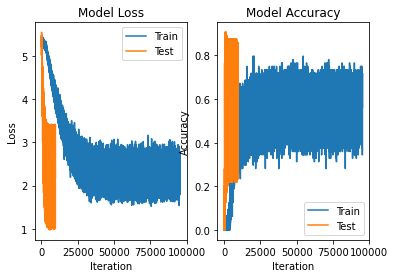

In [45]:
fig, axs = plt.subplots(1, 2)
inception_result.full_analysis(axs)

And save the results:

In [47]:
inception_result.save(_def_save_filename)

In [69]:
torch.save(
    inception, 
    os.path.join(
        os.path.abspath(""),
        "inception.pt"
    )
)

Let's produce some better training graphs.

In [97]:
with open(
    os.path.join(
        os.path.abspath(""),
        "..",
        "progress_save_0_588414.pt"
    ),
    "rb"
) as file_obj:
    results_dict = pickle.load(file_obj)

In [98]:
train_hist = results_dict["train_loss_history"]
val_hist = results_dict["val_loss_history"]

In [99]:
ratio = len(train_hist) // len(val_hist)

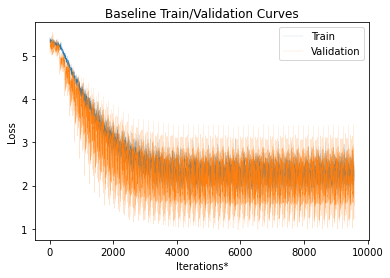

In [100]:
plt.plot(train_hist[:-(len(train_hist) % len(val_hist)):ratio], linewidth=0.1, label="Train")
plt.plot(val_hist, linewidth=0.1, label="Validation")
plt.title("Baseline Train/Validation Curves")
plt.xlabel("Iterations*")
plt.ylabel("Loss")
plt.legend()
plt.savefig("baseline_classifier_curves.png")

#### Stability Trained

Let's stability train ResNet. We can use the same datasets and loaders. Let's prepare the model object.

In [59]:
stable_inception = RobustInception().to(device)

First, a quick sanity check of gradients:

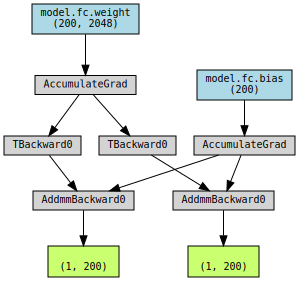

In [60]:
gradient_sanity_display(
    stable_inception,
    [next(iter(inception_train_loader))[0][0].reshape(1, 3, 299, 299)]
)

Next sanity check, how are the weights?

In [61]:
print(list(stable_inception.model.fc.parameters()))

[Parameter containing:
tensor([[ 1.7087e-02, -1.4549e-02,  1.9692e-02,  ...,  1.1724e-04,
          1.6022e-02, -1.6139e-02],
        [-2.9827e-05, -3.7509e-03,  1.9768e-02,  ...,  1.1229e-02,
         -2.5679e-03,  1.2240e-03],
        [ 8.4411e-03, -1.7445e-02, -2.1717e-02,  ...,  1.1512e-02,
          9.1533e-03,  5.8767e-03],
        ...,
        [ 5.1067e-03,  1.6294e-02,  2.1069e-02,  ..., -1.8345e-02,
         -1.7566e-02, -2.0346e-02],
        [-1.3686e-02,  4.7218e-03, -4.4959e-03,  ..., -1.7235e-02,
          1.3644e-02,  4.6310e-03],
        [ 1.2465e-02, -2.2704e-04,  7.5900e-04,  ..., -1.0308e-02,
         -9.9035e-03,  1.9962e-03]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.0023, -0.0147,  0.0044,  0.0221,  0.0212,  0.0108,  0.0027,  0.0022,
         0.0177,  0.0128, -0.0091,  0.0070,  0.0026, -0.0038,  0.0200, -0.0177,
        -0.0171,  0.0082,  0.0162, -0.0061, -0.0089, -0.0049,  0.0203, -0.0213,
        -0.0088,  0.0181, -0.0019, -0.0115, -

Learning controllers, same parameters as before:

In [62]:
s_inception_optimizer = optim.SGD(stable_inception.parameters(), lr=0.002)
s_inception_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    s_inception_optimizer,
    factor=0.5,
    patience=2,
    threshold=0.1
)
# May try OneCycleLR, annealers

Loss function:

In [37]:
s_inception_loss = full_loss

Keep the result in here:

In [64]:
s_inception_result = TrainResult(stable_inception)

The actual training loop:

In [65]:
s_inception_best_loss = float("inf")
s_inception_best_count = 0

In [66]:
# Train for some number of epochs
S_INCEPTION_EPOCH_COUNT = 30
S_INCEPTION_SAVE_PERIOD = 3

for epoch in tqdm_variant(
    range(S_INCEPTION_EPOCH_COUNT),
    desc=f"Epoch",
    unit="epoch",
    disable=False
):
    # Debug learning rate
    print(
        f"Current Learning Rate: {s_inception_optimizer.param_groups[0]['lr']}"
    )
    
    # Train
    train_loss = classifier_epoch(
        stable_inception,
        inception_train_loader,
        s_inception_optimizer,
        device,
        s_inception_loss,
        s_inception_result,
        stability_training=True
    )

    # Validation
    val_loss = classifier_epoch(
        stable_inception,
        inception_val_loader,
        s_inception_optimizer,
        device,
        s_inception_loss,
        s_inception_result,
        training=False,
        stability_training=True
    )
    
    # Update scheduling
    s_inception_scheduler.step(val_loss)
    
    # Save a copy just in case
    if val_loss < s_inception_best_loss:
        torch.save(
            stable_inception, 
            os.path.join(
                os.path.abspath(""),
                f"best_stable_inception_classifier_{s_inception_best_count}" \
                f"_{int(time.time()) % 100000:06}.pt"
            )
        )
        s_inception_best_count += 1
        s_inception_best_loss = val_loss
        
    if epoch % S_INCEPTION_SAVE_PERIOD == S_INCEPTION_SAVE_PERIOD - 1:
        torch.save(
            stable_inception,
            os.path.join(
                os.path.abspath(""),
                f"stable_inception_classifier_{epoch}_" \
                f"{int(time.time()) % 100000:06}.pt"
            )
        )

    # Print the average loss calculated and the epoch
    print(f"\nEpoch {epoch}: Training Loss: {train_loss}, " \
          f"Validation Loss: {val_loss}")

Epoch:   0%|          | 0/30 [00:00<?, ?epoch/s]

Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 0: Training Loss: 5.2372254333813375, Validation Loss: 5.091539966073006
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 1: Training Loss: 4.934521377353583, Validation Loss: 4.842755615331565
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 2: Training Loss: 4.648966420406115, Validation Loss: 4.582925058474206
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 3: Training Loss: 4.37949418106372, Validation Loss: 4.360514722811948
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 4: Training Loss: 4.128880751262623, Validation Loss: 4.1327666218873045
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 5: Training Loss: 3.8945116548300245, Validation Loss: 3.9375910819715756
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 6: Training Loss: 3.683570105832735, Validation Loss: 3.7782312806244867
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 7: Training Loss: 3.4888572120849553, Validation Loss: 3.559417613752329
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 8: Training Loss: 3.3178773933088483, Validation Loss: 3.4125317039003797
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 9: Training Loss: 3.161511972937459, Validation Loss: 3.3036772005117623
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 10: Training Loss: 3.029231918979286, Validation Loss: 3.171195644481926
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 11: Training Loss: 2.906802993513267, Validation Loss: 3.0271689011033174
Current Learning Rate: 0.002


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 12: Training Loss: 2.804939120836313, Validation Loss: 3.000949662202483
Current Learning Rate: 0.001


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 13: Training Loss: 2.7292094267261233, Validation Loss: 2.9360937996275105
Current Learning Rate: 0.001


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 14: Training Loss: 2.6887889761079675, Validation Loss: 2.9140760875811242
Current Learning Rate: 0.001


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 15: Training Loss: 2.6498042490721816, Validation Loss: 2.8582849289960923
Current Learning Rate: 0.001


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 16: Training Loss: 2.60841796402739, Validation Loss: 2.8012938264069285
Current Learning Rate: 0.0005


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 17: Training Loss: 2.5803083208075566, Validation Loss: 2.7848401229093027
Current Learning Rate: 0.0005


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 18: Training Loss: 2.5655388782517083, Validation Loss: 2.8170601949570284
Current Learning Rate: 0.0005


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 19: Training Loss: 2.548877005461158, Validation Loss: 2.7542598589210754
Current Learning Rate: 0.00025


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 20: Training Loss: 2.536918832717305, Validation Loss: 2.7579138081544525
Current Learning Rate: 0.00025


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 21: Training Loss: 2.525394939567825, Validation Loss: 2.7364291575304263
Current Learning Rate: 0.00025


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 22: Training Loss: 2.5199361098399926, Validation Loss: 2.776621441172946
Current Learning Rate: 0.000125


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 23: Training Loss: 2.5117525888877426, Validation Loss: 2.743469786492123
Current Learning Rate: 0.000125


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 24: Training Loss: 2.50985982428738, Validation Loss: 2.7296383327739253
Current Learning Rate: 0.000125


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 25: Training Loss: 2.507556921155958, Validation Loss: 2.7637733661445085
Current Learning Rate: 6.25e-05


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 26: Training Loss: 2.5041791887063667, Validation Loss: 2.778049897995724
Current Learning Rate: 6.25e-05


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 27: Training Loss: 2.4990405033432515, Validation Loss: 2.7080798574314
Current Learning Rate: 6.25e-05


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 28: Training Loss: 2.4984357154148173, Validation Loss: 2.725290393373769
Current Learning Rate: 3.125e-05


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 29: Training Loss: 2.4982522647501333, Validation Loss: 2.7546825272262474


Let's view the results:

Spent 23357 seconds training.
Spent 2243 seconds evaluating.


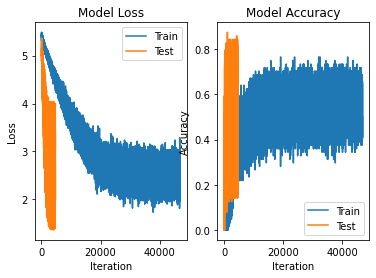

In [67]:
fig, axs = plt.subplots(1, 2)
s_inception_result.full_analysis(axs)

Next, let's save it with a special name.

In [68]:
torch.save(
    stable_inception, 
    os.path.join(
        os.path.abspath(""),
        "stability_inception.pt"
    )
)
s_inception_result.save(_def_save_filename)

Let's get some better plots:

In [101]:
with open(
    os.path.join(
        os.path.abspath(""),
        "..",
        "progress_save_0_616414.pt"
    ),
    "rb"
) as file_obj:
    results_dict = pickle.load(file_obj)

In [102]:
train_hist = results_dict["train_loss_history"]
val_hist = results_dict["val_loss_history"]

In [103]:
ratio = len(train_hist) // len(val_hist)

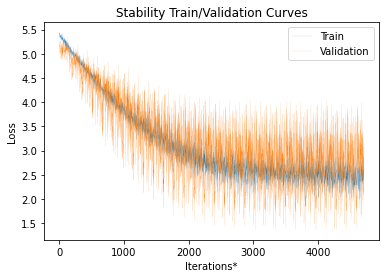

In [104]:
plt.plot(train_hist[:-(len(train_hist) % len(val_hist)):ratio], linewidth=0.1, label="Train")
plt.plot(val_hist, linewidth=0.1, label="Validation")
plt.title("Stability Train/Validation Curves")
plt.xlabel("Iterations*")
plt.ylabel("Loss")
plt.legend()
plt.savefig("stability_classifier_curves.png")

### Triplet Ranking

Next, let's train some triplet ranking models.

#### Baseline

Prepare data:

In [33]:
train_path = os.path.join(data_dir, "train")
val_path = os.path.join(data_dir, "val")
#trd = TripletRankingDataset(train_path, 2, 2, transform=inception_transform)
trd_val = TripletRankingDataset(
    val_path,
    1,
    1,
    transform=inception_transform,
    training=False
)

batch_size = 32
#tr_train_loader = torch.utils.data.DataLoader(trd, batch_size=batch_size,
                                     #num_workers=0, shuffle=True)
tr_val_loader = torch.utils.data.DataLoader(trd_val, batch_size=batch_size,
                                     num_workers=0)

Prepare new model that maps into a 64 dimensional encoding space. Note that this is less than the 200 classes.

In [34]:
inception_encoder = torchvision.models.inception_v3(
    pretrained=True,
    aux_logits=False
)

In [35]:
# Set them all to frozen by default
for param in inception_encoder.parameters():
    param.requires_grad = False

In [36]:
# Let's thaw some layers
for param in inception_encoder.Mixed_7c.parameters():
    param.requires_grad = True

In [37]:
inception_encoder.fc = nn.Linear(2048, 64) # 64-Dimensional Encoding

inception_triplet_ranking = TripletRanker(inception_encoder).to(device)

Training controllers:

In [52]:
#itr_optimizer = optim.SGD(inception_triplet_ranking.parameters(), lr=0.005)
itr_optimizer = optim.Adam(
    inception_triplet_ranking.parameters(),
    lr=0.005,
    betas=(0.8,0.99)
)
#itr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    #itr_optimizer,
    #factor=0.5,
    #patience=2,
    #threshold=0.1
#)
# May try OneCycleLR, annealers

Result:

In [39]:
itr_result = TrainResult(inception_triplet_ranking)

Triplet loss:

In [40]:
itr_loss = nn.TripletMarginLoss(1.0, 2)

Training loop:

In [41]:
itr_best_loss = float("inf")
itr_best_count = 0

In [53]:
# Train for some number of epochs
ITR_EPOCH_COUNT = 15 # with no normalization, + 16 + 1
ITR_SAVE_PERIOD = 1

loss = torch.Tensor([0])
for epoch in tqdm_variant(
    range(ITR_EPOCH_COUNT),
    desc=f"Epoch",
    unit="epoch",
    disable=False
):
    # For this training loop, we'll switch up the data each time.
    print("Loading data...")
    try:
        del trd, tr_train_loader
    except NameError:
        pass
    trd = TripletRankingDataset(train_path, 1, 1, transform=inception_transform)
    tr_train_loader = torch.utils.data.DataLoader(trd, batch_size=batch_size,
                                         num_workers=0, shuffle=True)
    print("...done.")
    
    # Debug learning rate
    print(f"Current Learning Rate: {itr_optimizer.param_groups[0]['lr']}")
    
    train_loss = triplet_epoch(
        inception_triplet_ranking,
        tr_train_loader,
        itr_optimizer,
        device,
        itr_loss,
        itr_result
    )

    val_loss = triplet_epoch(
        inception_triplet_ranking,
        tr_val_loader,
        itr_optimizer,
        device,
        itr_loss,
        itr_result,
        training=False
    )
    
    # Save a copy for safety
    if val_loss < itr_best_loss:
        torch.save(
            inception_triplet_ranking, 
            os.path.join(
                os.path.abspath(""),
                f"best_itr_{itr_best_count}_{int(time.time()) % 1000000:06}.pt"
            )
        )
        itr_best_count += 1
        itr_best_loss = val_loss
        
    if epoch % ITR_SAVE_PERIOD == ITR_SAVE_PERIOD - 1:
        torch.save(
            inception_triplet_ranking,
            os.path.join(
                os.path.abspath(""),
                f"itr_{epoch}_{int(time.time()) % 1000000:06}.pt"
            )
        )

    # Print the last loss calculated and the epoch
    print(f"\nEpoch {epoch}: Training Loss: {train_loss}, " \
          f"Validation Loss: {val_loss}")

Epoch:   0%|          | 0/15 [00:00<?, ?epoch/s]

Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 0: Training Loss: 0.4004341648387909, Validation Loss: 0.3754558493963446
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 1: Training Loss: 0.3672840037536621, Validation Loss: 0.3674835697554361
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 2: Training Loss: 0.34829089056015017, Validation Loss: 0.3664518064274765
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 3: Training Loss: 0.33164853138923645, Validation Loss: 0.3645986601139029
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 4: Training Loss: 0.3178371453809738, Validation Loss: 0.36568494675496516
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 5: Training Loss: 0.3075065079665184, Validation Loss: 0.36260136440634344
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 6: Training Loss: 0.2971532835125923, Validation Loss: 0.3692831148902258
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 7: Training Loss: 0.2867655133199692, Validation Loss: 0.3667950142329684
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 8: Training Loss: 0.27496212601661685, Validation Loss: 0.37086490266762984
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 9: Training Loss: 0.2666996761536598, Validation Loss: 0.37325120055542205
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 10: Training Loss: 0.25871495096087455, Validation Loss: 0.36599684976779234
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 11: Training Loss: 0.24810040583372117, Validation Loss: 0.37677918007960337
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 12: Training Loss: 0.24421424782514572, Validation Loss: 0.3685946888721789
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 13: Training Loss: 0.23393585928440094, Validation Loss: 0.3819884740458891
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 14: Training Loss: 0.23031507392644882, Validation Loss: 0.38100931406640015


Let's double check gradient calculations went well:

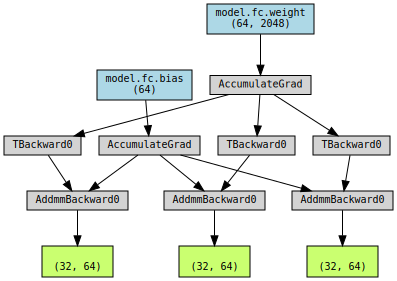

In [42]:
gradient_sanity_display(inception_triplet_ranking, next(iter(tr_train_loader)))

The old way of saving is taking up lots of memory, let's just save the part that changes:

In [59]:
torch.save(
    inception_triplet_ranking.model.state_dict(),
    "inception_triplet_ranking_2.pth"
)

In [60]:
itr_result.save(_def_save_filename)

Let's also take a look at training/testing curves:

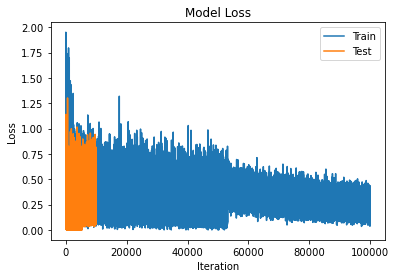

In [63]:
fig, ax = plt.subplots()
itr_result.plot_loss_train_valid_curves(ax)

## Experiments and Plot Generation

### Classifier vs. JPEG

We'll see how precision declines with more JPEG. First, let's load the classifiers from save files.

In [33]:
loaded_stabilized_inception = torch.load(
    os.path.join(
        os.path.abspath(""),
        "stability_inception.pt"
    ),
    device
)

loaded_baseline_inception = torch.load(
    os.path.join(
        os.path.abspath(""),
        "inception.pt"
    ),
    device
)

Sanity checks:

In [74]:
print(loaded_baseline_inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [75]:
print(loaded_stabilized_inception)

StabilityTrainingModel(
  (model): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_

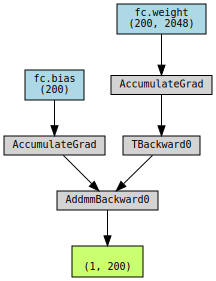

In [76]:
gradient_sanity_display(
    loaded_baseline_inception,
    [next(iter(inception_train_loader))[0][0].reshape(1, 3, 299, 299)]
)

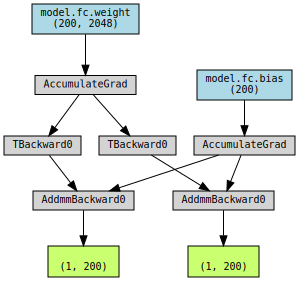

In [77]:
gradient_sanity_display(
    loaded_stabilized_inception,
    [next(iter(inception_train_loader))[0][0].reshape(1, 3, 299, 299)]
)

Looking good, so we're ready. We'll increase the JPEG levels as we experiment. Note that we can reuse some code for this. The data collection:

In [37]:
BATCH_SIZE = 64

qualities = list(range(100, 0, -10))
baseline_precision = [ ]
stabilized_precision = [ ]

for quality in tqdm_variant(
    qualities,
    desc=f"Experiment",
    unit="experiment"
):
    #
    # Prepare the data
    #
    apply_jpeg = JPEGTransform(quality)
    
    this_dataset = datasets.ImageFolder(
        os.path.join(data_dir, "val"),
        transform=T.Compose([apply_jpeg, inception_transform])
    )
    this_loader = torch.utils.data.DataLoader(
        this_dataset,
        batch_size=BATCH_SIZE,
        num_workers=0
    )
    
    tmp_result = TrainResult(None)

    #
    # Experiments
    #
    
    # Perform stabilized experiment
    _ = classifier_epoch(
            loaded_baseline_inception,
            this_loader,
            None,
            device,
            classifier_objective,
            tmp_result,
            training=False
        )
    _ = classifier_epoch(
            loaded_stabilized_inception,
            this_loader,
            None,
            device,
            full_loss,
            tmp_result,
            training=False,
            stability_training=True
        )
    
    #
    # Extract data
    #
    trial_size = len(tmp_result.val_accuracy_history) // 2
    inv_img_count = 1.0 / (len(this_dataset) // BATCH_SIZE)
    # Calculate baseline
    baseline_precision.append(
        sum(tmp_result.val_accuracy_history[:trial_size - 1]) * inv_img_count
    )
    stabilized_precision.append(
        sum(tmp_result.val_accuracy_history[trial_size:-1]) * inv_img_count
    )

    # No chances with memory management
    del tmp_result, this_loader, this_dataset

Experiment:   0%|          | 0/10 [00:00<?, ?experiment/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Let's plot the results:

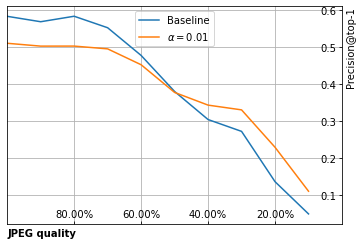

In [38]:
plot_precision_vs_quality(qualities, baseline_precision, stabilized_precision)

Next, let's save the results.

In [39]:
with open(
    f"inception_classifier_result_{int(time.time()) % 1000000:06}.pt",
    "wb"
) as file_obj:
    pickle.dump(
        {
            "baseline" : baseline_precision,
            "stabilized" : stabilized_precision
        }, file_obj
    )

### Feature Distances

First, run the experiment:

In [56]:
baseline_observations, stabilized_observations = make_observations(
    inception_triplet_ranking.model.to("cpu"),
    None,
    os.path.join(os.path.abspath(""), "tiny-imagenet-200", "test", "images")
)

  0%|          | 0/10001 [00:00<?, ?it/s]

Plot the results:

C:\Users\Gabriel\AppData\Local\Temp/ipykernel_1128/2350893480.py:32: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.set_yticklabels(
C:\Users\Gabriel\AppData\Local\Temp/ipykernel_1128/2350893480.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


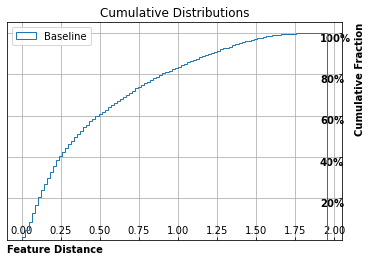

In [65]:
plot_cumulative_dist(
    list(map(lambda x : x.item(), baseline_observations)),
    stabilized_observations
)

Save the results for later:

In [58]:
with open(
    f"inception_tr_distribution_result_{int(time.time()) % 1000000:06}.pt",
    "wb"
) as file_obj:
    pickle.dump(
        {
            "baseline" : baseline_observations,
            "stabilized" : stabilized_observations
        }, file_obj
    )